In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125
import seaborn as sns
from Bio import SeqIO, Seq
import scipy.stats as st
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import glob, os, yaml, subprocess, itertools, sparse, pickle

who_variants = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/MIC_data/WHO_resistance_variants_all.csv")
pd.set_option('display.float_format', lambda x: '%.4f' % x)
samples_summary = pd.read_csv("../data/samples_summary.csv")
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'

import warnings
warnings.filterwarnings(action='ignore')

# Combined Analysis Files

In [2]:
def final_processing_and_validation(drug):
    '''
    Functions for processing outputs before sending to everyone else.
    
    1. Remove principal components (will describe them separately)
    2. Add LOF to the predicted_effect column for pooled LOF mutations
    3. Remove 2021 mutation catalog annotations (they were just for me to check that things make sense)
    4. Remove the logistic regression coefficient columns (they will prefer to work with odds ratios)
    5. Any other column renaming or dropping for clarity
    '''
    
    analysis_df = pd.read_csv(os.path.join(analysis_dir, drug, "final_analysis_with_univariate.csv"))
    analysis_df.rename(columns={"orig_variant": "mutation"}, inplace=True)
    
    # remove logReg coefficients. Keep only odds ratios. Remove the other two columns, which were present mainly for me to see
    # if we were picking up many mutations that were in the 2021 mutation catalog
    for col in ["genome_index", "confidence_WHO_2021"]:
        if col in analysis_df.columns:
            del analysis_df[col]
    analysis_df = analysis_df[analysis_df.columns[~analysis_df.columns.str.contains("coef")]]
    
    # replace all of the following variants with NaN for the univariate statistics
    analysis_df.loc[(analysis_df["mutation"].str.contains("PC")) | (analysis_df["HET"] == 'AF'), ['Num_Isolates', 'Total_Isolates', 'TP', 'FP', 'TN', 'FN', 'PPV', 'Sens', 'Spec', 'LR+', 'LR-']] = np.nan
    analysis_df.loc[(analysis_df["mutation"].str.contains("PC")) | (analysis_df["HET"] == 'AF') | (analysis_df["Odds_Ratio"] < 1) , ['PPV_LB', 'PPV_UB', 'Sens_LB', 'Sens_UB', 'Spec_LB', 'Spec_UB', 'LR+_LB', 'LR+_UB', 'LR-_LB', 'LR-_UB']] = np.nan
    
    if "Significant" in analysis_df.columns:
        del analysis_df["Significant"]
        
    analysis_df.loc[(analysis_df["Tier"] == 1) &
                    (analysis_df["Phenos"] == 'WHO') &
                    (analysis_df["unpooled"] == 0) &
                    (analysis_df["synonymous"] == 0) &
                    (analysis_df["HET"] == 'DROP') &
                    (analysis_df["BH_pval"] < 0.05), "Significant"
                   ] = 1

    analysis_df.loc[~((analysis_df["Tier"] == 1) &
                      (analysis_df["Phenos"] == 'WHO') &
                      (analysis_df["unpooled"] == 0) &
                      (analysis_df["synonymous"] == 0) & 
                      (analysis_df["HET"] == 'DROP')
                     ) & (analysis_df["BH_pval"] < 0.01), "Significant"
                    ] = 1

    analysis_df["Significant"] = analysis_df["Significant"].fillna(0).astype(int)
    print(f'{len(analysis_df.loc[(analysis_df["mutation"].str.contains("PC")) & (analysis_df["Significant"]==1)])} significant principal components for {drug}')
    
    # remove significant principal components and replace the NaNs in the predicted effect column for the gene loss of functions
    analysis_df = analysis_df.loc[~analysis_df["mutation"].str.contains("PC")]
    
    # predicted effect should not be NaN for anything. position is NaN only for the pooled LOF mutations
    assert len(analysis_df.loc[pd.isnull(analysis_df["predicted_effect"])]) == 0
    assert len(analysis_df.query("Significant==1 & BH_pval > 0.01 & BH_pval < 0.05")[["mutation", 'Tier', 'Phenos', 'unpooled', 'synonymous', 'HET']].drop_duplicates(['Tier', 'Phenos', 'unpooled', 'synonymous', 'HET'])) == 1
    
    # reorder columns
    analysis_df = analysis_df[['mutation', 'predicted_effect', 'position', 'Odds_Ratio', 'pval', 'BH_pval', 'Bonferroni_pval', "Significant",
       'Num_Isolates', 'Total_Isolates', 'TP', 'FP', 'TN', 'FN', 'PPV', 'Sens', 'Spec', 'LR+', 'LR-',
       'OR_LB', 'OR_UB', 'PPV_LB', 'PPV_UB', 'Sens_LB', 'Sens_UB', 'Spec_LB', 'Spec_UB', 'LR+_LB', 'LR+_UB', 'LR-_LB', 'LR-_UB', 
                               'Tier', 'Phenos', 'unpooled', 'synonymous', 'HET'
                              ]]
            
    return analysis_df

# Write Final Dataframes to an Excel File and Generate Volcano Plots

In [3]:
finished_drugs = np.sort(['Amikacin', 'Clofazimine', 'Linezolid', 'Bedaquiline', 'Delamanid', 'Ethionamide', 
                  'Moxifloxacin', 'Capreomycin', 'Pyrazinamide',
                  'Kanamycin', 'Levofloxacin', 'Streptomycin',
                  # 'Ethambutol', 'Rifampicin', 'Isoniazid'
                 ])

drug_analyses = {}
for drug in finished_drugs:

    drug_analyses[drug] = final_processing_and_validation(drug)
    
    new_analysis = pd.read_csv(os.path.join(analysis_dir, drug, "final_analysis_with_univariate.csv"))
    
    # old file version. Check that if it's there, the variants it contains are a subset of the file with new results
    if os.path.isfile(os.path.join(analysis_dir, drug, "combined_analyses.csv")):
        print(drug)
        prev_analysis = pd.read_csv(os.path.join(analysis_dir, drug, "combined_analyses.csv"))
        if len(set(prev_analysis.orig_variant) - set(new_analysis.orig_variant)) > 0:
            print(f"Il y a un problème avec {drug}!")
        else:
            os.remove(os.path.join(analysis_dir, drug, "combined_analyses.csv"))

1 significant principal components for Amikacin
2 significant principal components for Bedaquiline
1 significant principal components for Capreomycin
2 significant principal components for Clofazimine
1 significant principal components for Delamanid
0 significant principal components for Ethionamide
2 significant principal components for Kanamycin
1 significant principal components for Levofloxacin
1 significant principal components for Linezolid
2 significant principal components for Moxifloxacin
4 significant principal components for Pyrazinamide
3 significant principal components for Streptomycin


In [4]:
# write results to an Excel file, where each sheet is named for a drug
with pd.ExcelWriter("../results/Farhat_logReg_analysis.xlsx") as file:
   
    for key, val in drug_analyses.items():
        val.to_excel(file, sheet_name=key, index=False)

In [5]:
def volcano_plot(df, drug, plot_x="log-OR", plot_y="log_neg_log_pval", pval_col="BH_pval", color_col="Significant", or_thresh=0, saveFig=None):
    '''
    This function generates a volcano scatterplot of p-values against odds ratios to visualize the results for each drug. 
    
    It generates 2 plots for each drug: one for the primary analyses and another for the additional variants picked up by the secondary analyses. Separating them makes the secondary results
    easier to see because the effect sizes for those are much smaller, and they can get obscured by the primary analysis results. 
    
    Arguments:
    
        df = dataframe of results
        plot_x = column in df to plot as the x variable
        plot_y = column in df to plot as the y variable
        pval_col = p-value column to plot (i.e. p-value, Bonferroni, or Benjamini-Hochberg)
        drug = drug name for plotting
        color_col = column in df to color point by. Default is Significant
        or_thresh = to clean up the plot, you can exclude some mutations with very small effect sizes. or_thresh should be a value in [0, ∞). i.e. a threshold of 0.01 will
                    exclude variants with odds ratios in [0.99, 1.01]
        save_fig = file name to save plot to. If it is None, the plot is rendered in the notebook.
        
    Primary analysis: Tier = 1, Phenos = WHO, unpooled = False, synonymous = False, HET mutations = DROP
    
    The function computes the log odds ratio, negative logarithm of p-values, and the logarithm of the negative log of p-values. All of these can be plotted. 
    
    '''
    plot_df = df.copy()
    lower, upper = 1 - or_thresh, 1 + or_thresh
    plot_df = plot_df.query("Odds_Ratio < @lower | Odds_Ratio > @upper")
    
    if or_thresh > 0:
        print(f"Excluded {len(df) - len(plot_df)} variants from plotting")
    
    if plot_df[pval_col].min() == 0:
        second_smallest = np.sort(np.unique(plot_df[pval_col]))[1]
        plot_df[pval_col] += second_smallest
        
    plot_df["neg_log_pval"] = -np.log(plot_df[pval_col])
    plot_df["log_neg_log_pval"] = np.log(plot_df["neg_log_pval"])
    plot_df["log-OR"] = np.log(plot_df["Odds_Ratio"])
    plot_df.loc[(plot_df["Tier"]==1) & 
                (plot_df["Phenos"]=='WHO') & 
                (plot_df["unpooled"]==0) & 
                (plot_df["synonymous"]==0) & 
                (plot_df["HET"]=='DROP'), 
                "Analysis"] = "Primary"
    plot_df["Analysis"] = plot_df["Analysis"].fillna("Secondary")
        
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.scatterplot(data=plot_df.query("Analysis=='Primary'"), 
                    x=plot_x, 
                    y=plot_y, 
                    alpha=0.8,
                    hue="Significant", 
                    linewidth=0.25,
                    edgecolor='white',
                    s=30,
                    palette={1:sns.color_palette("tab10").as_hex()[0], 0:"darkgray"},
                    #palette={"Primary": sns.color_palette("Set2").as_hex()[2], "Secondary": sns.color_palette("Set2").as_hex()[1]},
                    ax=ax[0]
                   )
    sns.scatterplot(data=plot_df.query("Analysis=='Secondary'"), 
                    x=plot_x, 
                    y=plot_y, 
                    alpha=0.8,
                    hue="Significant",
                    linewidth=0.25,
                    edgecolor='white',
                    s=30,
                    palette={1:sns.color_palette("tab10").as_hex()[0], 0:"darkgray"},
                    #palette={"Primary": sns.color_palette("Set2").as_hex()[2], "Secondary": sns.color_palette("Set2").as_hex()[1]},
                    ax=ax[1]
                   )
    
    if plot_x[:3] == 'log':
        center = 0
    else:
        center = 1
      
    for axis in ax:
        if plot_y[:3] == 'log':
            axis.set_ylabel("Log(-Log(p-value))")
        else:
            axis.set_ylabel("-Log(p-value)")

    bound_0 = np.max(np.abs(plot_df.query("Analysis=='Primary'")[plot_x] - center))*1.1
    bound_1 = np.max(np.abs(plot_df.query("Analysis=='Secondary'")[plot_x] - center))*1.1
        
    for axis in ax:
        axis.set_xlabel("Regression Log-Odds")
        axis.legend().set_visible(False)
        
    ax[0].set_title(f"Primary Analysis Results for {drug}")
    ax[0].set_xlim(center - bound_0, center + bound_0)
    
    ax[1].set_title(f"Secondary Analysis Results for {drug}")
    ax[1].set_xlim(center - bound_1, center + bound_1)

    sns.despine()
    
    if saveFig is not None:
        plt.savefig(saveFig, dpi=300, bbox_inches="tight")
    else:
        plt.show()
        
    return plot_df

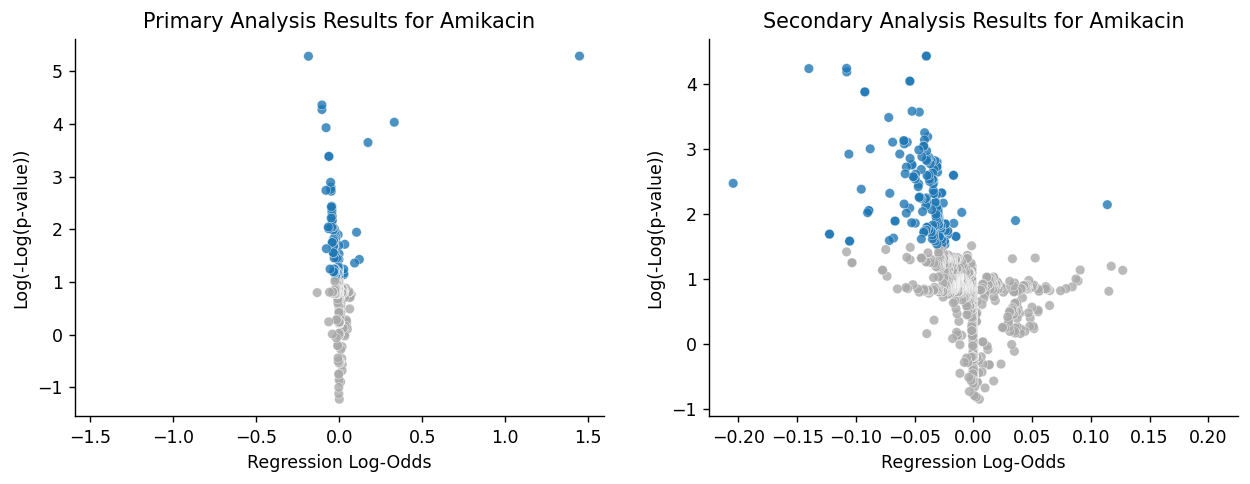

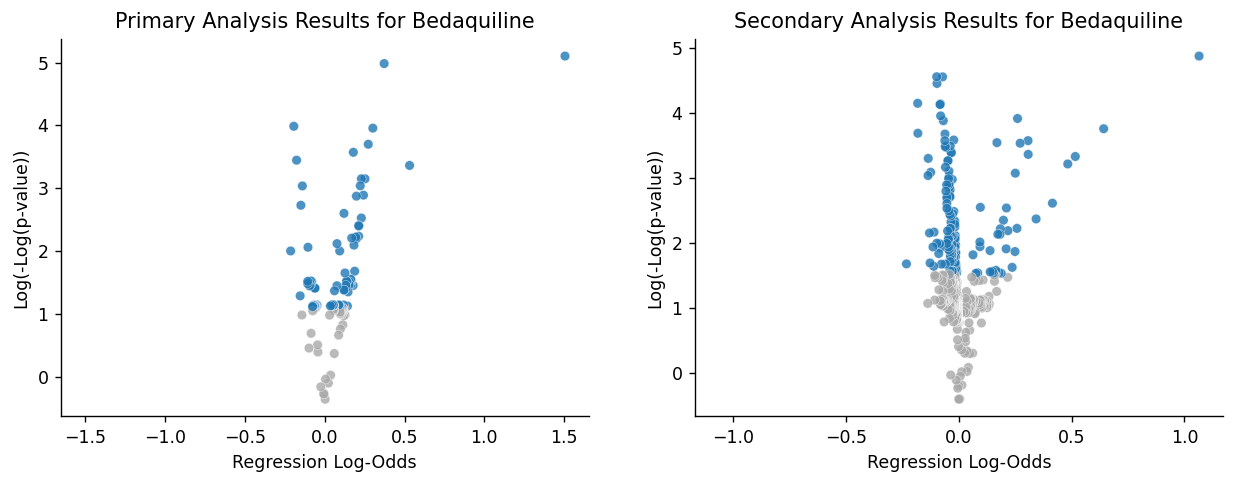

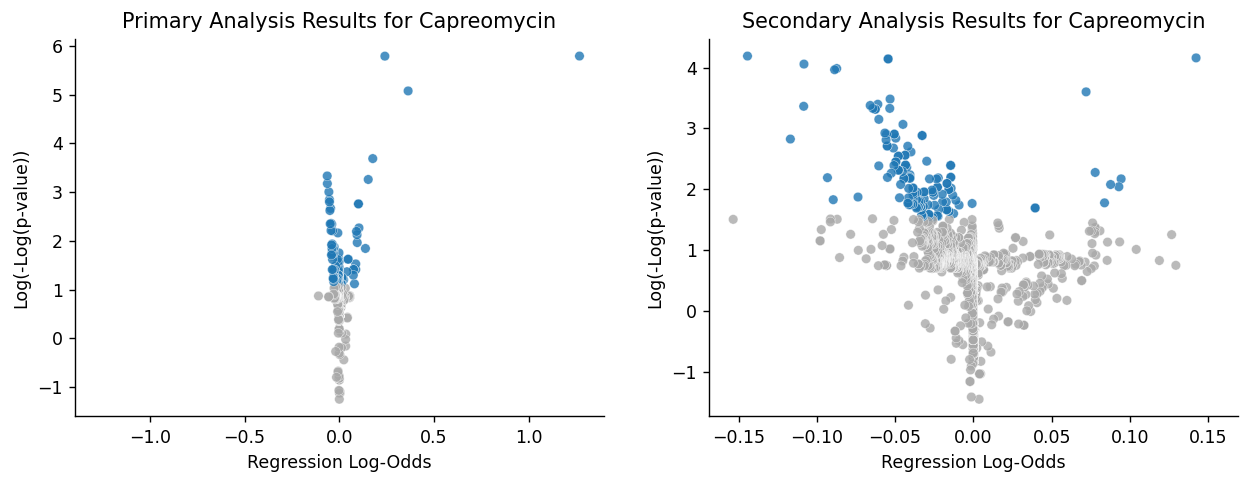

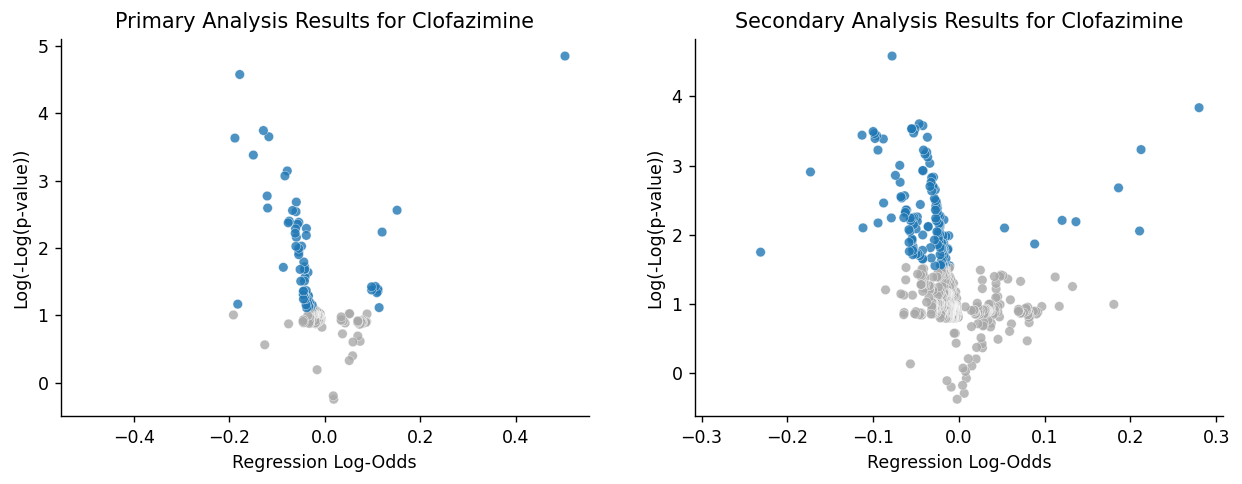

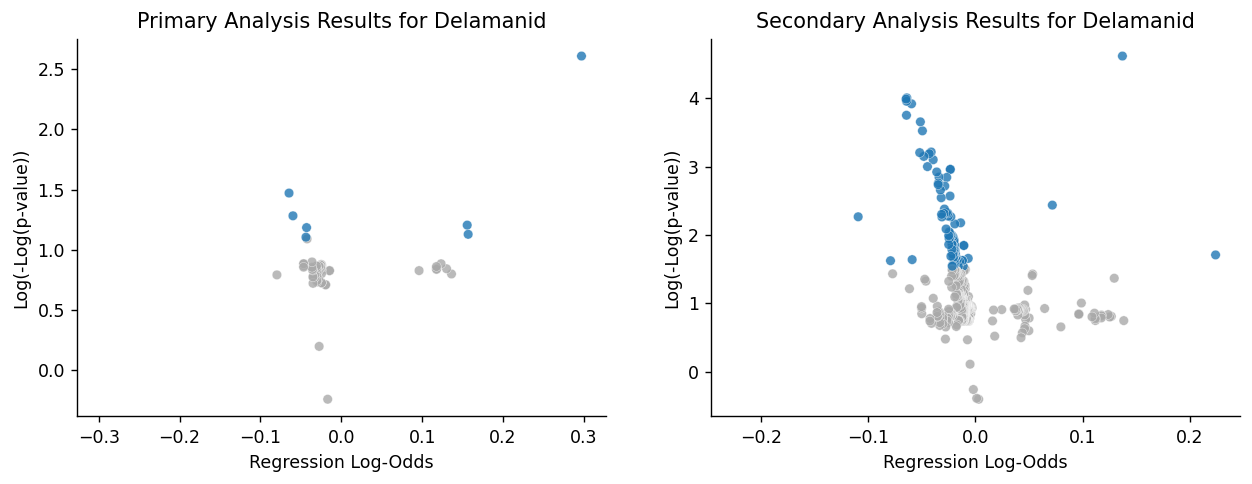

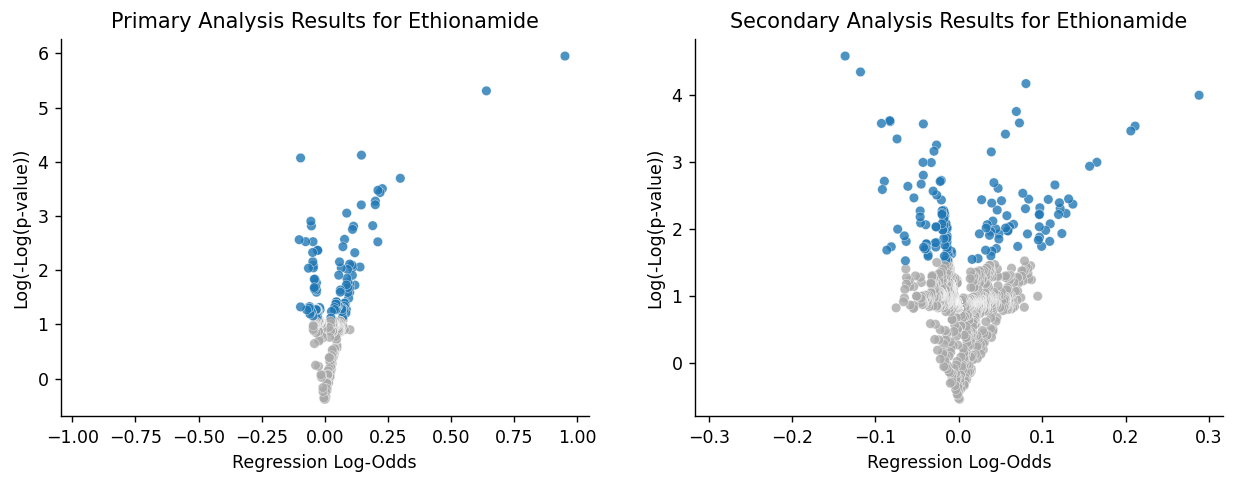

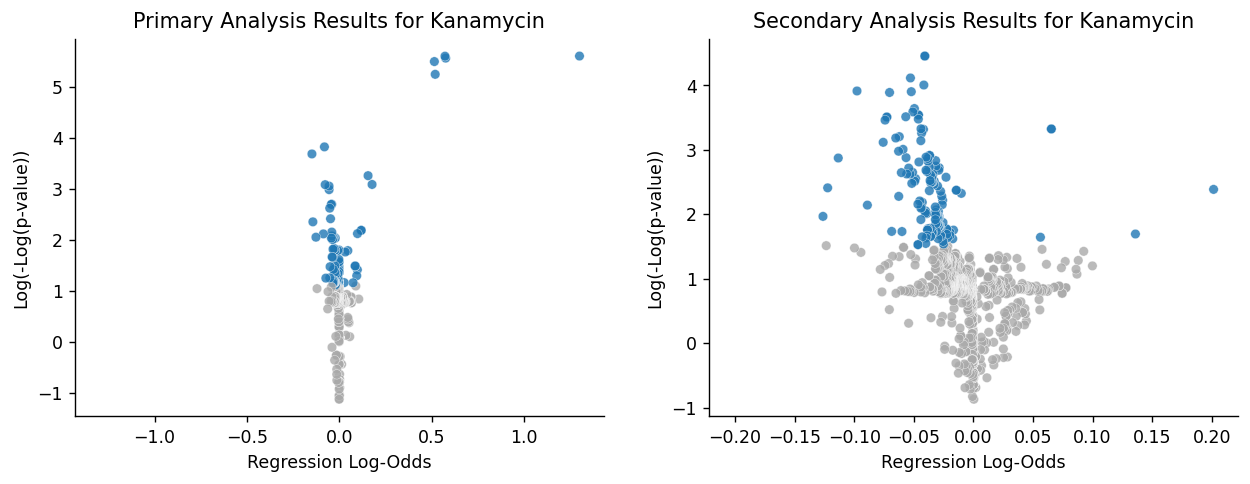

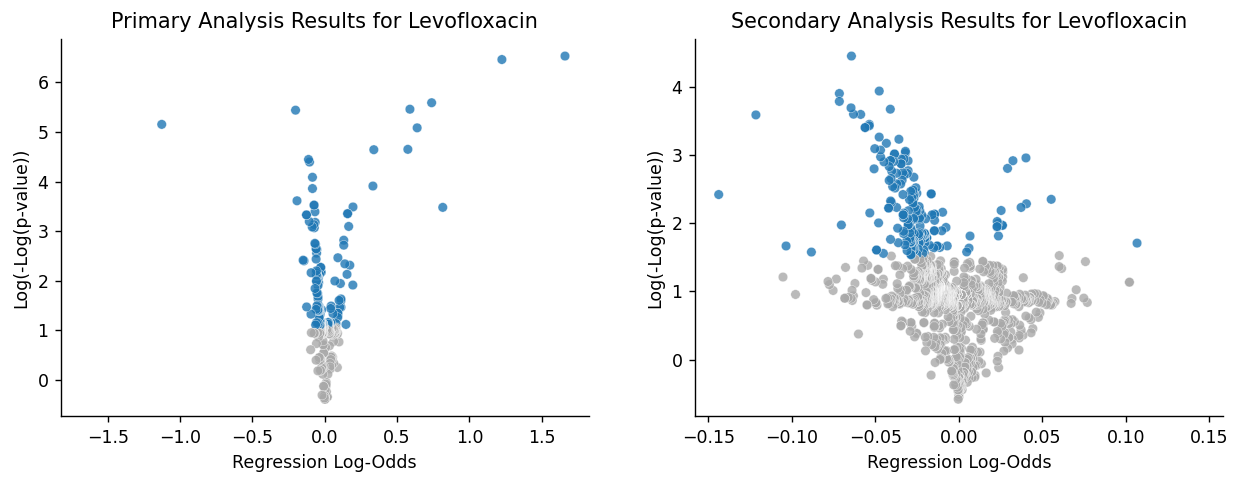

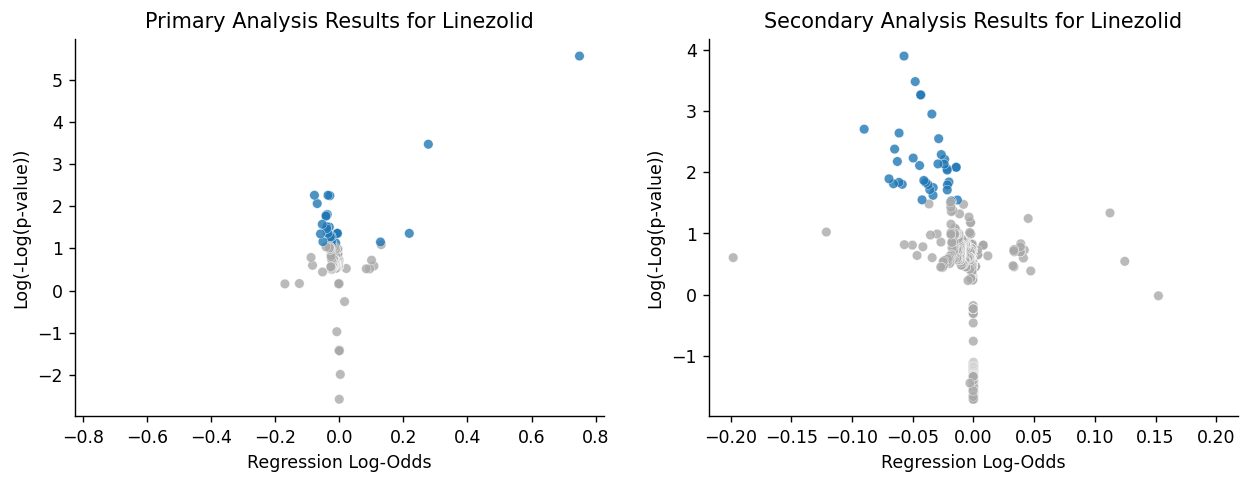

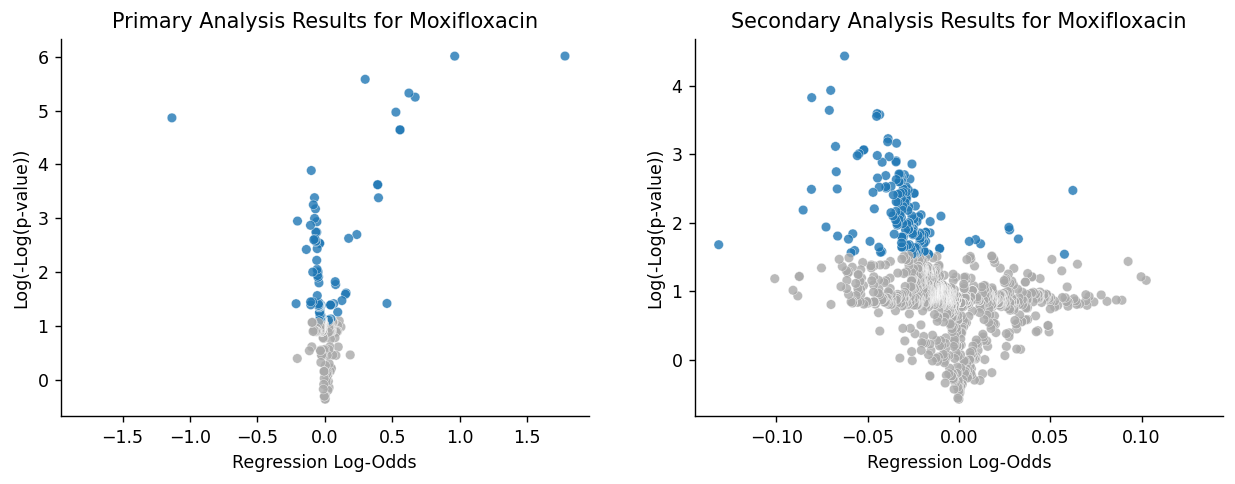

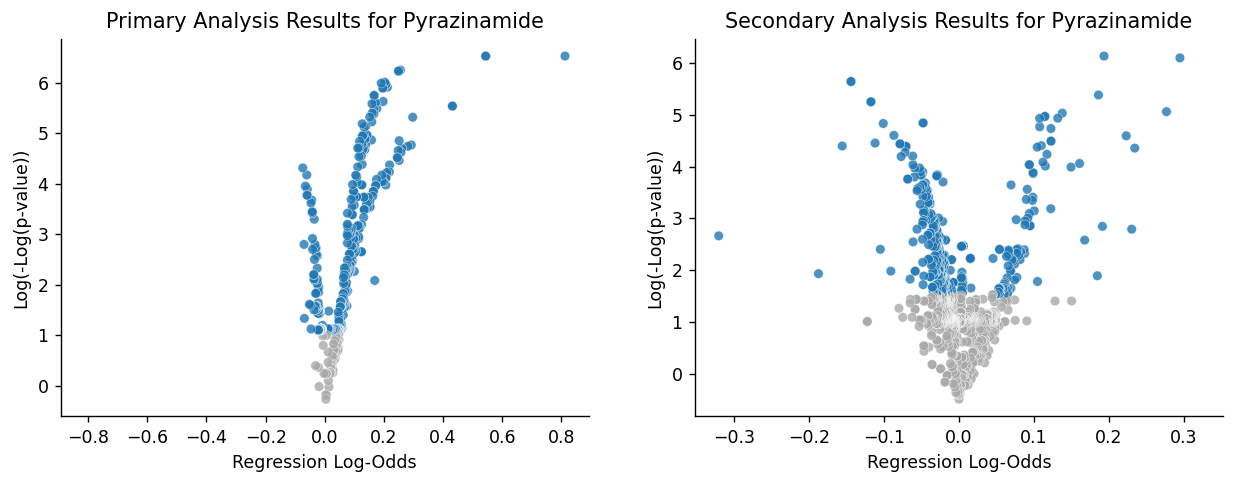

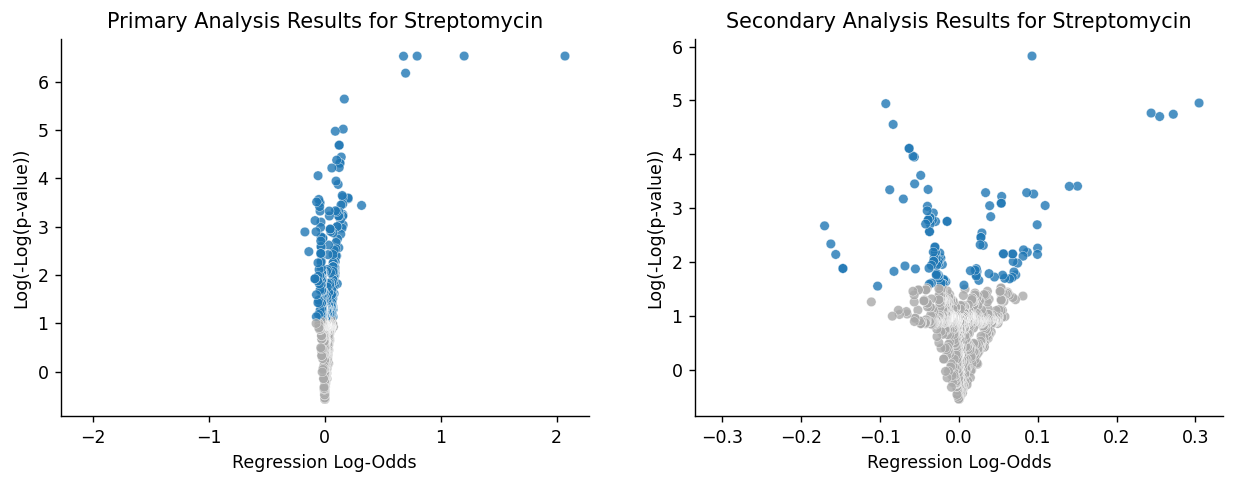

In [6]:
for drug in finished_drugs:
    _ = volcano_plot(drug_analyses[drug], drug, "log-OR", "log_neg_log_pval", "BH_pval", "Analysis", 0, saveFig=f"../results/{drug}_volcano.png")

# TODO: Get model metrics for every drug, and write them to a single CSV

In [3]:
results_df = pd.DataFrame(columns=["Drug", "Sensitivity", "Sens_Lower", "Sens_Upper", "Specificity", "Spec_Lower", "Spec_Upper", 
                                   "accuracy", "accuracy_Lower", "accuracy_Upper", "AUC", "AUC_Lower", "AUC_Upper"]).set_index("Drug")

def get_model_summary(drug, analyses_dict, results_df):
    
    var_lst = ["Sens", "Spec", "AUC", "accuracy"]
    name_lst = ["Sensitivity", "Specificity", "AUC", "accuracy"]
    summary_df = analyses_dict[drug]    
    
    # add the actual values
    results_df.loc[drug, name_lst] = summary_df.query("BS==0")[var_lst].values[0]
    
    # add the confidence intervals
    for i, variable in enumerate(var_lst):
        lower, upper = np.percentile(summary_df.query("BS==1")[variable], q=[2.5, 97.5])
        results_df.loc[drug, [variable + "_Lower", variable + "_Upper"]] = [lower, upper]
        assert lower <= results_df.loc[drug, name_lst[i]]
        assert upper >= results_df.loc[drug, name_lst[i]]
    
    return results_df

In [4]:
analyses_dict = {}
for drug in os.listdir(analysis_dir):
    
    if os.path.isfile(os.path.join(analysis_dir, drug, "core_logReg_summary.csv")):
        df = pd.read_csv(os.path.join(analysis_dir, drug, "core_logReg_summary.csv"))
        if len(df) == 1001:
            analyses_dict[drug] = df
            
for drug in list(analyses_dict.keys()):
    results_df = get_model_summary(drug, analyses_dict, results_df)

In [5]:
results_df

,Sensitivity,Sens_Lower,Sens_Upper,Specificity,Spec_Lower,Spec_Upper,accuracy,accuracy_Lower,accuracy_Upper,AUC,AUC_Lower,AUC_Upper
Drug,,,,,,,,,,,,
Levofloxacin,0.8918,0.8800,0.9046,0.9650,0.9608,0.9703,0.9490,0.9451,0.9536,0.9284,0.9226,0.9350
Pyrazinamide,0.6408,0.5890,0.6601,0.7641,0.7496,0.8084,0.7406,0.7296,0.7671,0.7025,0.6929,0.7106
Streptomycin,0.8995,0.8910,0.9188,0.9529,0.9343,0.9627,0.9312,0.9263,0.9357,0.9262,0.9231,0.9310
Amikacin,0.7620,0.7364,0.7923,0.9738,0.9551,0.9784,0.9459,0.9318,0.9518,0.8679,0.8554,0.8827
Ethambutol,0.7297,0.5315,0.7454,0.7749,0.7624,0.9686,0.7659,0.7589,0.8829,0.7523,0.7471,0.7751
Clofazimine,0.7674,0.6473,0.8261,0.6644,0.6463,0.7921,0.6689,0.6515,0.7865,0.7159,0.6906,0.7488
Linezolid,0.7917,0.7017,0.8596,0.9519,0.9335,0.9970,0.9488,0.9314,0.9930,0.8718,0.8354,0.9103
Moxifloxacin,0.9233,0.9093,0.9351,0.9424,0.9375,0.9515,0.9384,0.9337,0.9452,0.9329,0.9259,0.9398
Kanamycin,0.8118,0.7872,0.8315,0.9400,0.9337,0.9513,0.9132,0.9069,0.9220,0.8759,0.8647,0.8872


# TODO: Catalog-Based Method Comparison

After running the logistic regression models, see how its performance compares to an association-based model (i.e. if an isolate contains any category 1 or 2 mutation, it is resistant. Else susceptible)

In [ ]:
def get_logReg_summary(out_dir):
    
    model_summary = pd.read_csv(os.path.join(out_dir, "logReg_summary.csv"))
    model_analysis = pd.read_csv(os.path.join(out_dir, "model_analysis.csv"))
    
    summary_sens = model_summary.loc[0, "Sens"]
    summary_spec = model_summary.loc[0, "Spec"]
    
    #max_idx = [np.argmax(model_analysis["Sens"]), np.argmax(model_analysis["Spec"])]
    
    better_variant = model_analysis.query("Sens >= @summary_sens & Spec >= @summary_spec")
    
    if len(better_variant) == 0:
        print("No variants have comparable sensitivity AND specificity")
    else:
        print(better_variant)
    return model_summary, model_analysis
    
    #return model_summary, model_analysis.iloc[max_idx, :][["orig_variant", "coef", "Sens", "Spec", "accuracy", "balanced_accuracy"]]

In [ ]:
#out_dir = "/n/data1/hms/dbmi/farhat/ye12/who/analysis/Levofloxacin/tiers=1+2/phenos=ALL/dropAF_withSyn"
out_dir = "/n/data1/hms/dbmi/farhat/ye12/who/analysis/Pyrazinamide/tiers=1+2/phenos=WHO/dropAF_withSyn"

summary, analysis = get_logReg_summary(out_dir)
summary

In [ ]:
analysis.query("Sens > 0.9006")

In [ ]:
analysis.loc[analysis["orig_variant"].str.contains("PC")]

In [ ]:
analysis.query("Spec > 0.9575")

In [ ]:
out_dir = "/n/data1/hms/dbmi/farhat/ye12/who/analysis/Moxifloxacin/tiers=1+2/phenos=ALL/dropAF_withSyn"

get_logReg_summary(out_dir)

In [ ]:
df_pza = pd.read_csv("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Pyrazinamide/tiers=1+2/phenos=WHO/dropAF_withSyn/phenos.csv")

# the missing ones might be M. cannettii, most similar to L6 based on the other lineage callers
lineages = pd.read_pickle("../data/combined_lineage_sample_IDs.pkl")
lineages["Lineage"] = lineages["Lineage"].fillna("6")
lineages["Lineage_1"] = lineages["Lineage_1"].fillna("6")

lineages = lineages[["Sample Name", "Sample ID", "Lineage_1"]]
lineages["Lineage"] = [str(val).split(".")[0] for val in lineages["Lineage_1"].values]
lineages.loc[lineages["Lineage"].str.contains("BOV"), "Lineage"] = "M. bovis"

assert len(lineages.loc[pd.isnull(lineages["Lineage"])]) == 0

########## KEEP ONLY ISOLATES WITH ALL 3 PIECES OF DATA ##########

# get only isolates with data for everyting: SNP matrix, in the model, and lineages
combined = lineages.merge(df_pza, left_on="Sample ID", right_on="sample_id")

In [ ]:
combined.groupby("Lineage")["phenotype"].mean().sort_values(ascending=False)

In [ ]:
combined.query("Lineage == 'M. bovis'").Lineage_1.unique()